In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import random                             # randon numbers
from scipy.stats import norm              # Gaussian parametric distribution
import geostatspy.GSLIB as GSLIB
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import svm                                   # support vector machine methods
from sklearn import tree                    

# tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
import pandas.plotting as pd_plot
from intake import cat                                    # data catalogue
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from tqdm.notebook import trange, tqdm



well_df = pd.read_csv('wellData.csv')
day_df = pd.read_csv('dailyData.csv')

well_df = well_df.drop(['ESP_Motor_Frequency_Rating', 'Unnamed: 0', 'Artificial_Lift_Type'], axis =1)
well_df

,Well_ID,AL_Key,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth
0,345,ESP_2,9056.67,0,5.323174,NaN,NaN,NaN,1.713554
1,29,ESP_3,8982.09,0,6.440650,NaN,NaN,NaN,2.789395
2,327,ESP_1,8876.37,0,5.669751,NaN,NaN,NaN,0.481680
3,71,ESP_1,8930.11,0,5.614798,NaN,NaN,NaN,0.842038
4,125,ESP_2,8616.41,348,26.061750,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
161,341,ESP_1,7927.90,504,17.561921,NaN,NaN,NaN,NaN
162,143,ESP_1,8041.24,0,12.231519,NaN,NaN,NaN,NaN
163,258,ESP_1,7908.00,445,12.905506,NaN,NaN,NaN,9.620484
164,285,ESP_1,7958.81,415,12.924289,NaN,NaN,NaN,10.935088


In [2]:
day_df = day_df.drop(['Lower_Limit', 'Power_Difference', 'ESP Data - Motor Winding Temperature', 'Drive_Power','ESP Data - Output Frequency',
'Gas_through_Annulus_Intake','ESP Data - Drive Voltage','Discharge_Pressure','ESP Data - Motor Temperature Shutdown Setpoint',
'Gas_Saturation_at_Discharge','Pump_Average_Pressure','Pump_Power','ARTIFICIAL_LIFT',
'Power_Ratio','ESP Data - Drive Current','ESP Data - Vibration X','Startup_Count','Gas_through_Annulus','ESP_Fluid','Pb_ESP'], axis = 1)
day_df

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Intake Pressure,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_ESP_Intake,Gas_through_ESP,Pump_Delta_Pressure,Gas_Saturation_in_Pump,ESP_Temperature,AL_Key,Well_ID
0,615.154601,650.447788,526.488655,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
1,1224.193640,1232.455787,809.414685,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
2,1007.769762,1047.068544,667.933899,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
3,1514.641876,1370.143160,1122.137652,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
4,1089.741764,1387.138130,1156.169599,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50051,130.568357,335.639084,433.161488,0.0,894.599976,167.384209,444.562318,856.745525,611.946527,0.583339,0.537389,396.339903,184.730450,1703.463069,0.168102,168.679595,ESP_1,142
50052,135.061535,338.161005,421.979434,0.0,894.599976,173.144311,433.085059,858.684065,606.229370,0.586167,0.534518,399.702384,187.719102,1668.437442,0.171957,168.766911,ESP_1,142
50053,135.757477,341.732930,428.363835,0.0,893.432975,174.012642,439.638975,870.139131,613.651616,0.586430,0.533871,405.597021,189.694864,1663.311231,0.173214,168.672755,ESP_1,142
50054,64.788755,170.379740,221.002588,12.0,934.540501,83.449011,226.808990,413.161203,310.258001,0.571123,0.562801,180.633789,90.269617,1604.082202,0.162718,172.715382,ESP_1,142


In [3]:
new_df_2 = well_df.drop(['AL_Key'], axis = 1).copy()

imputer_2 = IterativeImputer(tol = 1e-2)
imputer_2.fit(new_df_2)
imputed_array_2 = imputer_2.transform(new_df_2)

imputed2_df = pd.DataFrame(imputed_array_2)
imputed2_df

,0,1,2,3,4,5,6,7
0,345.0,9056.67,0.0,5.323174,56.046929,3409.779481,309.252209,1.713554
1,29.0,8982.09,0.0,6.440650,54.279085,3739.342582,335.712037,2.789395
2,327.0,8876.37,0.0,5.669751,58.025138,3385.829184,307.680447,0.481680
3,71.0,8930.11,0.0,5.614798,55.299631,3679.213287,330.892139,0.842038
4,125.0,8616.41,348.0,26.061750,64.887168,2297.913622,233.736284,4.789396
...,...,...,...,...,...,...,...,...
161,341.0,7927.90,504.0,17.561921,78.077368,1324.215271,160.627653,5.899696
162,143.0,8041.24,0.0,12.231519,66.005019,3394.013203,310.617004,4.213202
163,258.0,7908.00,445.0,12.905506,76.710015,1623.538707,182.290634,9.620484
164,285.0,7958.81,415.0,12.924289,75.754476,1715.839933,188.750968,10.935088


In [4]:
names_well = new_df_2.columns

i = 0
static_df = imputed2_df.rename({i : names_well[i] for i in range(len(names_well))}, axis = 'columns')
    
static_df["AL_Key"] = well_df.loc[:,"AL_Key"]
static_df

,Well_ID,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,AL_Key
0,345.0,9056.67,0.0,5.323174,56.046929,3409.779481,309.252209,1.713554,ESP_2
1,29.0,8982.09,0.0,6.440650,54.279085,3739.342582,335.712037,2.789395,ESP_3
2,327.0,8876.37,0.0,5.669751,58.025138,3385.829184,307.680447,0.481680,ESP_1
3,71.0,8930.11,0.0,5.614798,55.299631,3679.213287,330.892139,0.842038,ESP_1
4,125.0,8616.41,348.0,26.061750,64.887168,2297.913622,233.736284,4.789396,ESP_2
...,...,...,...,...,...,...,...,...,...
161,341.0,7927.90,504.0,17.561921,78.077368,1324.215271,160.627653,5.899696,ESP_1
162,143.0,8041.24,0.0,12.231519,66.005019,3394.013203,310.617004,4.213202,ESP_1
163,258.0,7908.00,445.0,12.905506,76.710015,1623.538707,182.290634,9.620484,ESP_1
164,285.0,7958.81,415.0,12.924289,75.754476,1715.839933,188.750968,10.935088,ESP_1


In [5]:
new_df = day_df.drop(['AL_Key'], axis = 1).copy()

imputer = IterativeImputer(tol = 5e-2)
imputer.fit(new_df)
imputed_array = imputer.transform(new_df)

imputed_df = pd.DataFrame(imputed_array)
imputed_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,615.154601,650.447788,526.488655,11.0,900.299057,817.675335,549.168696,1000.047637,1366.844031,0.448059,0.564779,547.055461,489.759719,1561.663184,0.212914,176.711681,345.0
1,1224.193640,1232.455787,809.414685,0.0,-673.410530,1214.497584,846.658798,1979.450120,2061.156381,0.576477,0.632190,483.534935,618.906643,2755.706448,0.103872,175.932896,345.0
2,1007.769762,1047.068544,667.933899,0.0,-141.645168,1076.066702,700.393185,1683.014791,1776.459887,0.545280,0.605923,512.268127,579.949897,2306.452700,0.142367,176.936687,345.0
3,1514.641876,1370.143160,1122.137652,0.0,-1276.327140,1416.804908,1162.967000,2299.790430,2579.771907,0.577727,0.658148,476.033439,631.507883,3355.692823,0.042272,168.463033,345.0
4,1089.741764,1387.138130,1156.169599,0.0,-180.444334,1094.509424,1191.846372,2086.363353,2286.355796,0.568422,0.630243,507.078305,692.887345,2565.239967,0.090550,166.864558,345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50051,130.568357,335.639084,433.161488,0.0,894.599976,167.384209,444.562318,856.745525,611.946527,0.583339,0.537389,396.339903,184.730450,1703.463069,0.168102,168.679595,142.0
50052,135.061535,338.161005,421.979434,0.0,894.599976,173.144311,433.085059,858.684065,606.229370,0.586167,0.534518,399.702384,187.719102,1668.437442,0.171957,168.766911,142.0
50053,135.757477,341.732930,428.363835,0.0,893.432975,174.012642,439.638975,870.139131,613.651616,0.586430,0.533871,405.597021,189.694864,1663.311231,0.173214,168.672755,142.0
50054,64.788755,170.379740,221.002588,12.0,934.540501,83.449011,226.808990,413.161203,310.258001,0.571123,0.562801,180.633789,90.269617,1604.082202,0.162718,172.715382,142.0


In [6]:
names = new_df.columns

i = 0
imputed_df = imputed_df.rename({i : names[i] for i in range(len(names))}, axis = 'columns')
    
imputed_df["AL_Key"] = day_df.loc[:,"AL_Key"]
imputed_df

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Intake Pressure,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_ESP_Intake,Gas_through_ESP,Pump_Delta_Pressure,Gas_Saturation_in_Pump,ESP_Temperature,Well_ID,AL_Key
0,615.154601,650.447788,526.488655,11.0,900.299057,817.675335,549.168696,1000.047637,1366.844031,0.448059,0.564779,547.055461,489.759719,1561.663184,0.212914,176.711681,345.0,ESP_2
1,1224.193640,1232.455787,809.414685,0.0,-673.410530,1214.497584,846.658798,1979.450120,2061.156381,0.576477,0.632190,483.534935,618.906643,2755.706448,0.103872,175.932896,345.0,ESP_2
2,1007.769762,1047.068544,667.933899,0.0,-141.645168,1076.066702,700.393185,1683.014791,1776.459887,0.545280,0.605923,512.268127,579.949897,2306.452700,0.142367,176.936687,345.0,ESP_2
3,1514.641876,1370.143160,1122.137652,0.0,-1276.327140,1416.804908,1162.967000,2299.790430,2579.771907,0.577727,0.658148,476.033439,631.507883,3355.692823,0.042272,168.463033,345.0,ESP_2
4,1089.741764,1387.138130,1156.169599,0.0,-180.444334,1094.509424,1191.846372,2086.363353,2286.355796,0.568422,0.630243,507.078305,692.887345,2565.239967,0.090550,166.864558,345.0,ESP_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50051,130.568357,335.639084,433.161488,0.0,894.599976,167.384209,444.562318,856.745525,611.946527,0.583339,0.537389,396.339903,184.730450,1703.463069,0.168102,168.679595,142.0,ESP_1
50052,135.061535,338.161005,421.979434,0.0,894.599976,173.144311,433.085059,858.684065,606.229370,0.586167,0.534518,399.702384,187.719102,1668.437442,0.171957,168.766911,142.0,ESP_1
50053,135.757477,341.732930,428.363835,0.0,893.432975,174.012642,439.638975,870.139131,613.651616,0.586430,0.533871,405.597021,189.694864,1663.311231,0.173214,168.672755,142.0,ESP_1
50054,64.788755,170.379740,221.002588,12.0,934.540501,83.449011,226.808990,413.161203,310.258001,0.571123,0.562801,180.633789,90.269617,1604.082202,0.162718,172.715382,142.0,ESP_1


In [7]:
index_day_df = imputed_df.set_index(["Well_ID", "AL_Key"])


In [14]:
days_to_failure = imputed_df.groupby(["Well_ID", "AL_Key"], sort=False)["OIL"].count()

days_to_failure

Well_ID  AL_Key
345.0    ESP_2     431
29.0     ESP_3     407
327.0    ESP_1     356
71.0     ESP_1     367
125.0    ESP_2     128
                  ... 
341.0    ESP_1       1
143.0    ESP_1      37
258.0    ESP_1     262
285.0    ESP_1     398
142.0    ESP_1     428
Name: OIL, Length: 165, dtype: int64

In [9]:
L30_daily_df = []
for _iter in tqdm(index_day_df.index.unique()):
    sub_df = index_day_df.loc[_iter]
    L30_daily_df.append(sub_df.tail(30))
    
L30_daily_df = pd.concat(L30_daily_df)
L30_daily_df

  0%|          | 0/165 [00:00<?, ?it/s]

/tmp/ipykernel_29768/1723267808.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = index_day_df.loc[_iter]


OIL         GAS       WATER  DOWN_TIME_HOURS  \
Well_ID AL_Key                                                        
345.0   ESP_2   342.990580  594.173422  351.208567              0.0   
        ESP_2   320.258097  579.186096  317.956414              2.0   
        ESP_2   368.765764  624.923558  410.109889              0.0   
        ESP_2   324.828073  567.879093  320.114847              2.0   
        ESP_2   331.743892  602.440954  373.719175              0.0   
...                    ...         ...         ...              ...   
142.0   ESP_1   130.568357  335.639084  433.161488              0.0   
        ESP_1   135.061535  338.161005  421.979434              0.0   
        ESP_1   135.757477  341.732930  428.363835              0.0   
        ESP_1    64.788755  170.379740  221.002588             12.0   
        ESP_1     0.000000    0.000000    0.000000             24.0   

                ESP Data - Intake Pressure  Oil_Intake  Water_Intake  \
Well_ID AL_Key                                                         
345.0   ESP_2                   854.548535  438.178355    359.757315   
        ESP_2                   855.526667  409.173186    325.695422   
        ESP_2                   851.166957  470.963117    420.093915   
        ESP_2                   853.931618  414.952246    327.906968   
        ESP_2                   856.324621  423.878363    382.815103   
...                                    ...         ...           ...   
142.0   ESP_1                   894.599976  167.384209    444.562318   
        ESP_1                   894.599976  173.144311    433.085059   
        ESP_1                   893.432975  174.012642    439.638975   
        ESP_1                   934.540501   83.449011    226.808990   
        ESP_1                  1527.854901    0.000000      0.000000   

                 Gas_Intake  Liquid_Intake  Gas_Saturation_at_Intake  \
Well_ID AL_Key                                                         
345.0   ESP_2   1454.082952     797.935670                  0.645680   
        ESP_2   1433.244380     734.868608                  0.661056   
        ESP_2   1527.008513     891.057032                  0.631500   
        ESP_2   1394.854393     742.859214                  0.652498   
        ESP_2   1490.738637     806.693466                  0.648872   
...                     ...            ...                       ...   
142.0   ESP_1    856.745525     611.946527                  0.583339   
        ESP_1    858.684065     606.229370                  0.586167   
        ESP_1    870.139131     613.651616                  0.586430   
        ESP_1    413.161203     310.258001                  0.571123   
        ESP_1      0.000000       0.000000                  0.362751   

                Gas_Separator_Efficiency  Gas_through_ESP_Intake  \
Well_ID AL_Key                                                     
345.0   ESP_2                   0.464965              777.985756   
        ESP_2                   0.449011              789.701568   
        ESP_2                   0.477860              797.312872   
        ESP_2                   0.458851              754.824525   
        ESP_2                   0.460936              803.602897   
...                                  ...                     ...   
142.0   ESP_1                   0.537389              396.339903   
        ESP_1                   0.534518              399.702384   
        ESP_1                   0.533871              405.597021   
        ESP_1                   0.562801              180.633789   
        ESP_1                   0.581213              481.744218   

                Gas_through_ESP  Pump_Delta_Pressure  Gas_Saturation_in_Pump  \
Well_ID AL_Key                                                                 
345.0   ESP_2        381.816902             7.102833                0.710910   
        ESP_2        376.792255           -15.299701                0.728436   
        ESP_2       

In [10]:
B30_daily_df = []
for _iter in tqdm(index_day_df.index.unique()):
    sub_df = index_day_df.loc[_iter]
    B30_daily_df.append(sub_df.head(30))
    
B30_daily_df = pd.concat(B30_daily_df)

  0%|          | 0/165 [00:00<?, ?it/s]

/tmp/ipykernel_29768/941701409.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = index_day_df.loc[_iter]


In [15]:
corr_matrix = B30_daily_df.corr()
corr_matrix

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Intake Pressure,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_ESP_Intake,Gas_through_ESP,Pump_Delta_Pressure,Gas_Saturation_in_Pump,ESP_Temperature
OIL,1.000000,0.734408,0.310484,-0.245494,-0.061576,0.937741,0.317604,-0.053058,0.757489,-0.312068,-0.344650,-0.298153,0.749701,-0.060743,-0.404141,0.095585
GAS,0.734408,1.000000,0.271115,-0.272250,-0.120245,0.653365,0.277150,0.215929,0.563988,-0.024430,-0.303201,-0.061731,0.827372,0.071331,-0.269495,0.069743
WATER,0.310484,0.271115,1.000000,-0.259421,0.268045,0.299055,0.999558,-0.077684,0.823862,-0.470573,-0.331864,-0.183639,0.284018,0.093292,-0.511549,-0.378472
DOWN_TIME_HOURS,-0.245494,-0.272250,-0.259421,1.000000,0.011475,-0.199307,-0.260214,-0.082033,-0.285918,0.115554,0.032163,0.069316,-0.193628,-0.082175,0.267136,0.103838
ESP Data - Intake Pressure,-0.061576,-0.120245,0.268045,0.011475,1.000000,0.243092,0.261640,-0.760379,0.312599,-0.725541,-0.146366,-0.507784,0.318648,-0.811657,-0.129029,-0.144087
Oil_Intake,0.937741,0.653365,0.299055,-0.199307,0.243092,1.000000,0.306542,-0.331357,0.786942,-0.502141,-0.429593,-0.449572,0.844591,-0.344527,-0.364523,0.162994
Water_Intake,0.317604,0.277150,0.999558,-0.260214,0.261640,0.306542,1.000000,-0.084274,0.828553,-0.473752,-0.334994,-0.193906,0.291939,0.097632,-0.512871,-0.351412
Gas_Intake,-0.053058,0.215929,-0.077684,-0.082033,-0.760379,-0.331357,-0.084274,1.000000,-0.249543,0.826786,-0.012630,0.841086,-0.300227,0.694880,0.131583,-0.305910
Liquid_Intake,0.757489,0.563988,0.823862,-0.285918,0.312599,0.786942,0.828553,-0.249543,1.000000,-0.602477,-0.469854,-0.390148,0.686059,-0.139373,-0.546884,-0.131920
Gas_Saturation_at_Intake,-0.312068,-0.024430,-0.470573,0.115554,-0.725541,-0.502141,-0.473752,0.826786,-0.602477,1.000000,-0.063588,0.803057,-0.428434,0.510654,0.494941,-0.023508


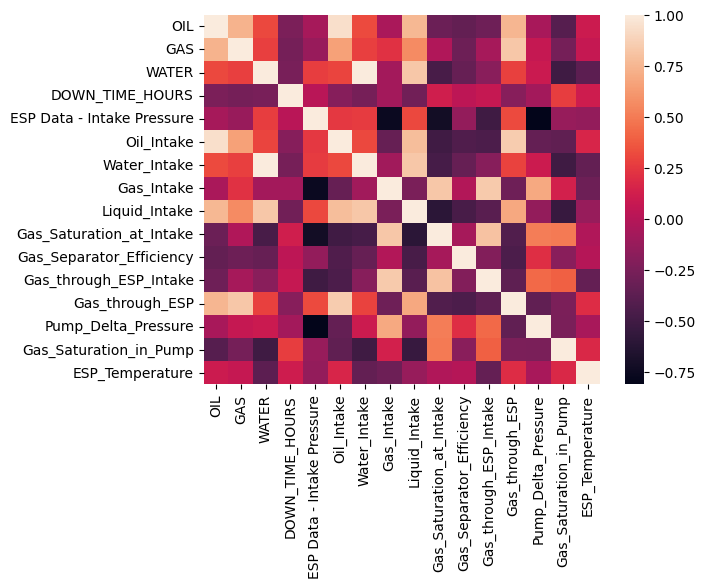

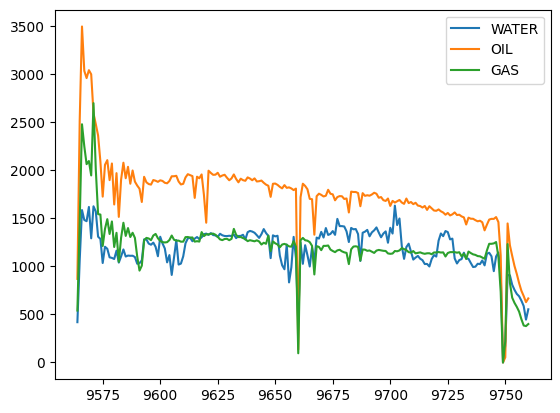

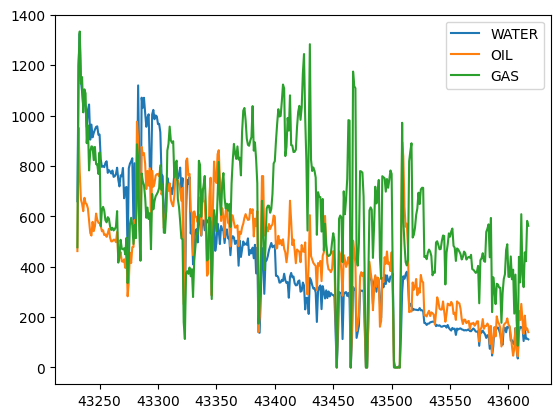

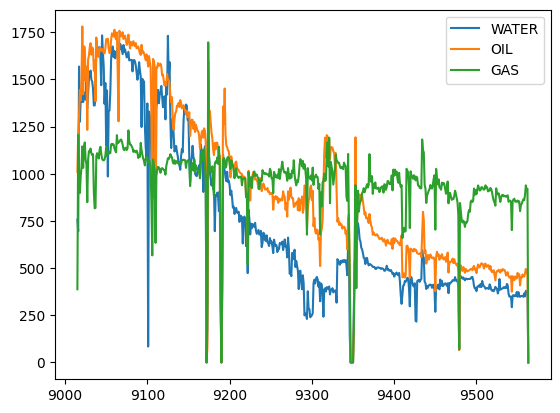

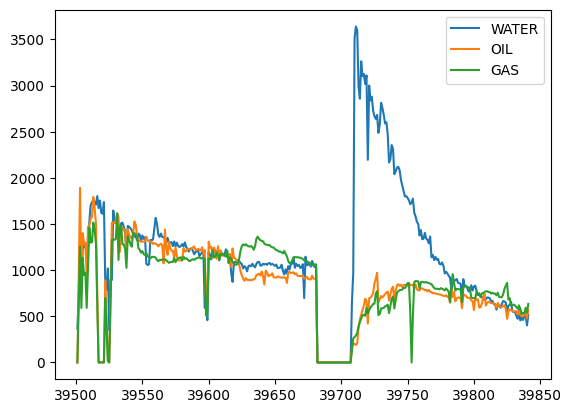

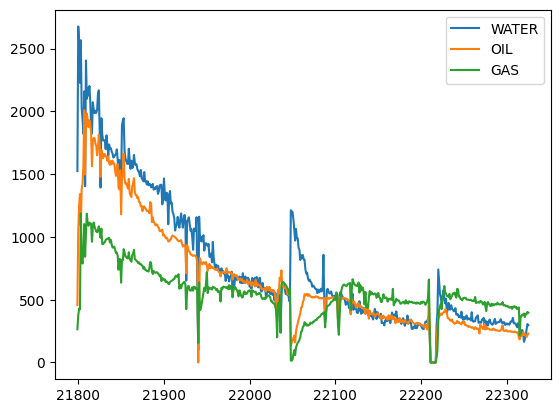

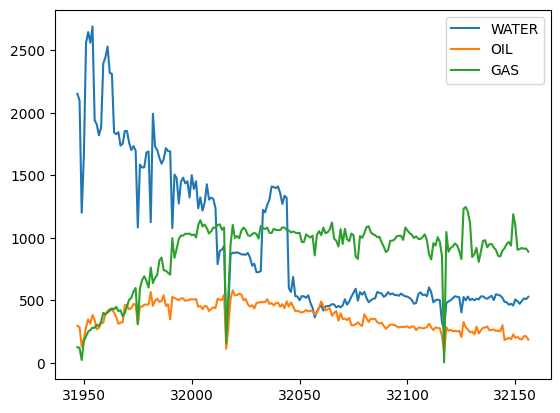

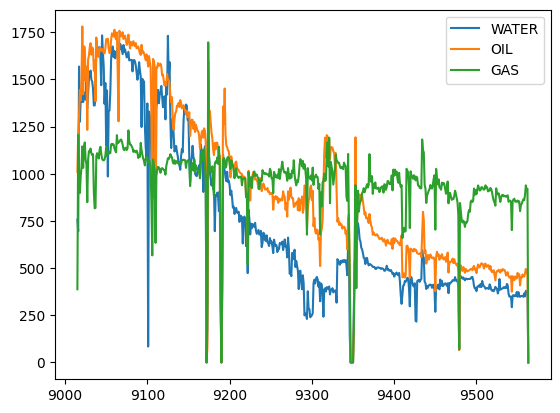

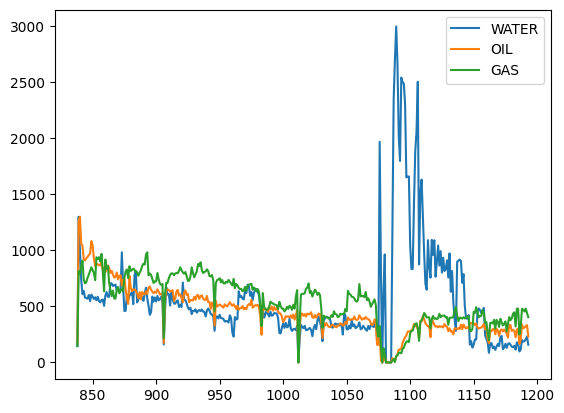

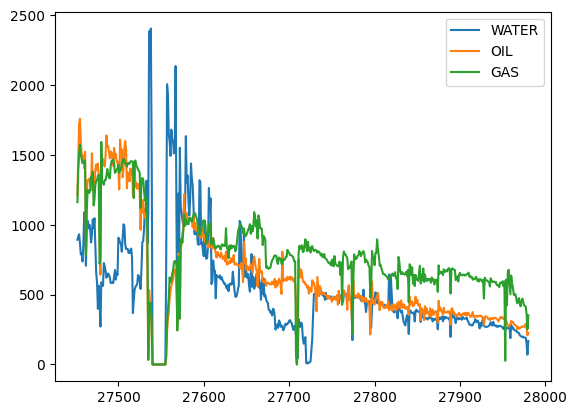

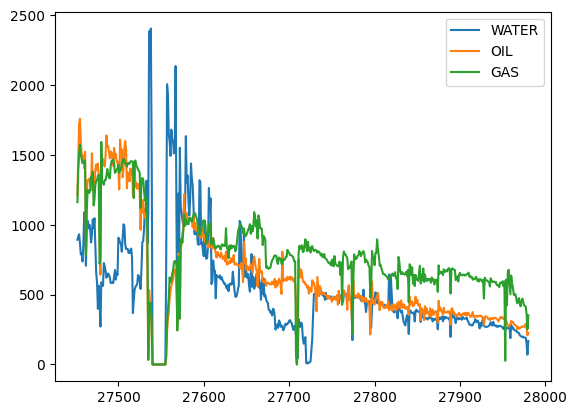

In [16]:
sn.heatmap(corr_matrix, annot=False)
columns =  [ 'WATER','OIL','GAS']
import random
for i in range(10):
    
    df2 = pd.read_csv('dailyData.csv')
    well_ids = df2['Well_ID']
    id_ = random.choice(well_ids)
    df_filtered = df2[df2['Well_ID'] == id_]
    df_filtered[columns].plot()
plt.show()

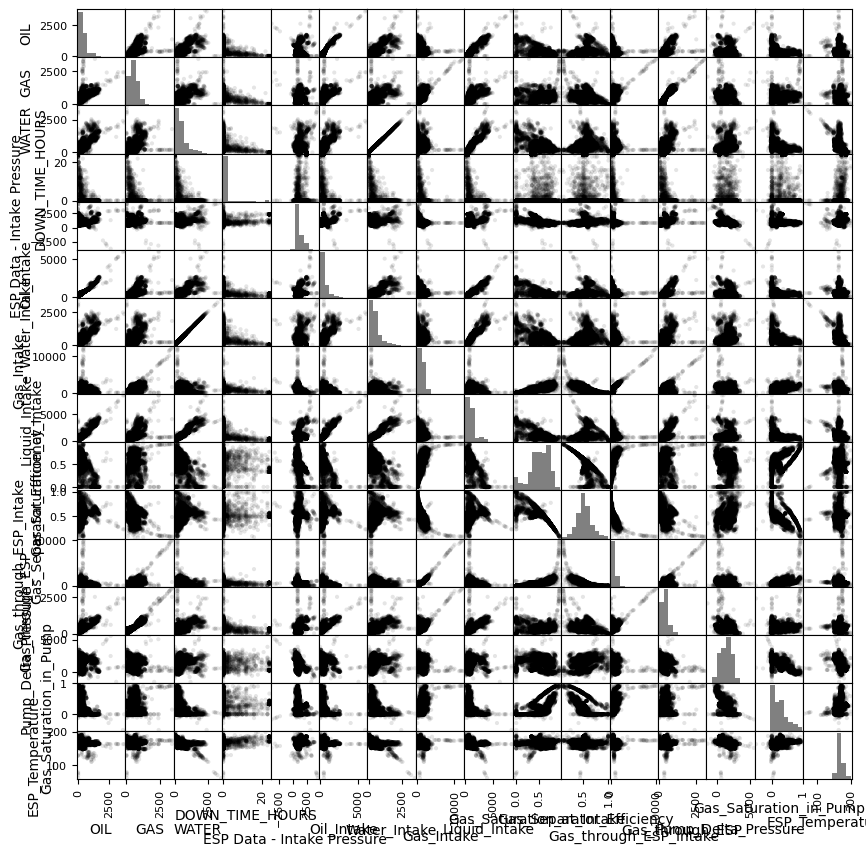

In [13]:
pd_plot.scatter_matrix(L30_daily_df, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()